### Evaluation of Variational Autoencoder (VAE) for Credit Card

## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

![The Method](method.png)

Source: [scikit-learn.org - Cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html#cross-validation-and-model-selection)

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from pandas import DataFrame as df
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearn_pipeline

from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from pyod.models.vae import VAE

from pprint import pprint
from time import time

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5
CKP_PREFIX = 'CC_'

np.random.seed(RANDOM_STATE)

# pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 1. Prepare data & Partition the data into 80-20 train-test split

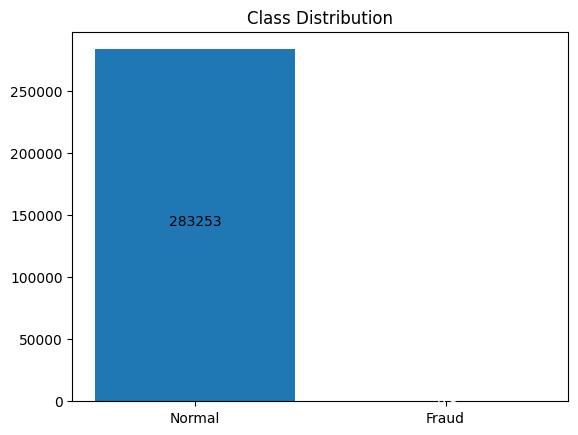

In [29]:
# Importing the dataset
path_to_data = '../data/creditcard/creditcard.csv'

# col names data set
col_names = [
    "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","label"
] # V1-V28 are PCA transformed features, but are anonymized due to confidentiality reasons and are not interpretable
# Label is 1 if fraud, 0 otherwise

# read full data set
data = pd.read_csv(path_to_data, names=col_names, index_col=0, header=0)

# drop duplicates  & time column
data.drop_duplicates(inplace=True)
data.drop("Time", axis=1, inplace=True)

# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

# Stratified 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# create label mapping
label_mapping = {"normal": 0, "fraud": 1}
normal_label = label_mapping["normal"]
fraud_label = label_mapping["fraud"]

# Visualize class imbalance
plt.bar(["Normal", "Fraud"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1])
normal_percentage = (data["label"].value_counts()[0])

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage}', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage}', ha='center', color='white')
plt.title("Class Distribution")
plt.show()

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns)
    ]
)

### 2. Define Models and Perform Cross-Validation on the training data

In [21]:
# Initialize cross-validation
kf = StratifiedKFold(n_splits=CROSS_VAL_SPLITS, shuffle=True, random_state=RANDOM_STATE)

f1_scores = []
precision_scores = []
recall_scores = []

# Define hyperparameters
EPOCHS = 10
BATCH_SIZE = 32

# for train_index, val_index in kf.split(X_train, y_train):
for (i, (train_index, val_index)) in enumerate(kf.split(X_train, y_train)):
    print(f"\nFold {i+1}/{CROSS_VAL_SPLITS}")

    X_train_fold = X_train.iloc[train_index].copy()
    X_val_fold = X_train.iloc[val_index].copy()
    y_val_fold = y_train.iloc[val_index].copy()

    print("Fitting preprocessor...")
    # Fit preprocessor
    preprocessor.fit(X_train_fold)

    # transform data
    print("Transforming data...")
    X_train_fold = preprocessor.transform(X_train_fold)
    X_val_fold = preprocessor.transform(X_val_fold)
    print("Data transformed.")

    # check for nan
    print("nan values in X_train_fold: ", np.isnan(X_train_fold).any())

    print("Fitting VAE model...")
    clf = VAE(epoch_num=EPOCHS, batch_size=BATCH_SIZE, dropout_rate=0.2)
    clf.fit(X_train_fold)

    print("Predicting on validation set...")
    # Predict on validation set
    y_val_pred = clf.predict(X_val_fold)  # Predicted labels (0: inlier, 1: outlier)
    print("Predictions made.")

    print('Calculating metrics...')
    # Calculate metrics
    f1 = f1_score(y_val_fold, y_val_pred)
    precision = precision_score(y_val_fold, y_val_pred)
    recall = recall_score(y_val_fold, y_val_pred)
    
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Report mean and standard deviation of metrics
print("Cross-Validation Results:")
print(f"F1-Score: Mean={np.mean(f1_scores):.4f}, Std={np.std(f1_scores):.4f}")
print(f"Precision: Mean={np.mean(precision_scores):.4f}, Std={np.std(precision_scores):.4f}")
print(f"Recall: Mean={np.mean(recall_scores):.4f}, Std={np.std(recall_scores):.4f}")


Fold 1/5
Fitting preprocessor...
Transforming data...
Data transformed.
nan values in X_train_fold:  False
Fitting VAE model...


Training: 100%|██████████| 10/10 [01:30<00:00,  9.09s/it]


Predicting on validation set...
Predictions made.
Calculating metrics...

Fold 2/5
Fitting preprocessor...
Transforming data...
Data transformed.
nan values in X_train_fold:  False
Fitting VAE model...


Training: 100%|██████████| 10/10 [01:26<00:00,  8.65s/it]


Predicting on validation set...
Predictions made.
Calculating metrics...

Fold 3/5
Fitting preprocessor...
Transforming data...
Data transformed.
nan values in X_train_fold:  False
Fitting VAE model...


Training: 100%|██████████| 10/10 [01:27<00:00,  8.78s/it]


Predicting on validation set...
Predictions made.
Calculating metrics...

Fold 4/5
Fitting preprocessor...
Transforming data...
Data transformed.
nan values in X_train_fold:  False
Fitting VAE model...


Training: 100%|██████████| 10/10 [01:29<00:00,  8.92s/it]


Predicting on validation set...
Predictions made.
Calculating metrics...

Fold 5/5
Fitting preprocessor...
Transforming data...
Data transformed.
nan values in X_train_fold:  False
Fitting VAE model...


Training: 100%|██████████| 10/10 [01:28<00:00,  8.84s/it]


Predicting on validation set...
Predictions made.
Calculating metrics...
Cross-Validation Results:
F1-Score: Mean=0.0298, Std=0.0009
Precision: Mean=0.0152, Std=0.0005
Recall: Mean=0.9127, Std=0.0330


### 3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters

In [38]:
# Fit the preprocessor on the full training data
preprocessor.fit(X_train)

# Transform the filtered data without re-fitting
transformed_sample = preprocessor.transform(X_train)

# Check for NaNs
if np.isnan(transformed_sample).any():
    print("NaNs detected in the transformed data.")
else:
    print("No NaNs in the transformed data.")

# Proceed to fit your model
clf = VAE(epoch_num=EPOCHS, batch_size=BATCH_SIZE, dropout_rate=0.2)
clf.fit(transformed_sample)

No NaNs in the transformed data.


Training: 100%|██████████| 10/10 [01:54<00:00, 11.41s/it]


### 4. Final evaluation of the models

Recall: 0.85
Precision: 0.01
F1: 0.03


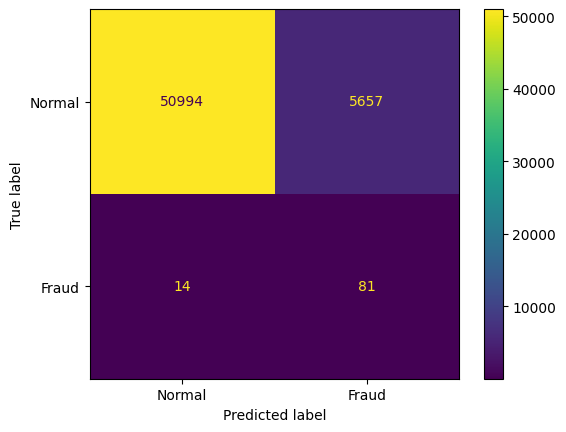

In [39]:
# predict
y_pred = clf.predict(preprocessor.transform(X_test))

# Evaluate the model
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1: {f1:.2f}")

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fraud"])
disp.plot()